In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=2e074fc0086039b1cff5f4f58d9bb509c0238ca4cd52c8efe18be5a0071cdb93
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# create spark context and spark session
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("MIS584_Lab_Assignment2")
#sc = SparkContext(conf = conf)

# Get or create a SparkContext
sc = SparkContext.getOrCreate()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MIS584_Lab_Assignment2").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from pyspark.sql.functions import col, length, sum
from pyspark.sql.functions import round
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings



# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("Read CSV and Show Schema") \
    .getOrCreate()


# Define the path to the CSV files
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/sales receipts.csv"
csv_file_path1 = "/content/drive/MyDrive/Colab Notebooks/product.csv"
csv_file_path2 = "/content/drive/MyDrive/Colab Notebooks/sales_outlet.csv"

# Use the read.csv function to read the CSV into a DataFrame
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
df1 = spark.read.csv(csv_file_path1, header=True, inferSchema=True)
df2 = spark.read.csv(csv_file_path2, header=True, inferSchema=True)


# Print the schema of the DataFrame
df.printSchema()
df1.printSchema()
df2.printSchema()

df.show(5);
df1.show(5);
df2.show(5);


# Check for missing values in the entire DataFrame
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts_1 = df1.select([sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns])
missing_counts_2 = df2.select([sum(col(c).isNull().cast("int")).alias(c) for c in df2.columns])

# Display the missing value counts for each column
missing_counts.show()
missing_counts_1.show()
missing_counts_2.show()


df.createOrReplaceTempView("df")
df1.createOrReplaceTempView("df1")



# Show the result
#result.show()

resultant_table = df.join(df1, on=['product_id'], how='left')

resultant_table.show()


final_table = resultant_table.join(df2, on=['sales_outlet_id'], how='left')


finalest_table = final_table.drop_duplicates()
finalest_table.show()
output_path = "/content/drive/MyDrive/finalcsv"

# Use the DataFrame write method to export to CSV
finalest_table.write.csv(output_path, header=True, mode="overwrite")







root
 |-- transaction_id: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- transaction_time: timestamp (nullable = true)
 |-- sales_outlet_id: integer (nullable = true)
 |-- staff_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- instore_yn: string (nullable = true)
 |-- order: integer (nullable = true)
 |-- line_item_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- line_item_amount: double (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- promo_item_yn: string (nullable = true)

root
 |-- product_id: integer (nullable = true)
 |-- product_group: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- product_type: string (nullable = true)
 |-- product: string (nullable = true)
 |-- product_description: string (nullable = true)
 |-- unit_of_measure: string (nullable = true)
 |-- current_wholesale_price: double (nullable = tr

### The results above show that all three datasets do not have null or missing values except for the manager column in the sales outlet dataset with 1 missing value

### All three datasets are now joined and the final dataset is what we will work with

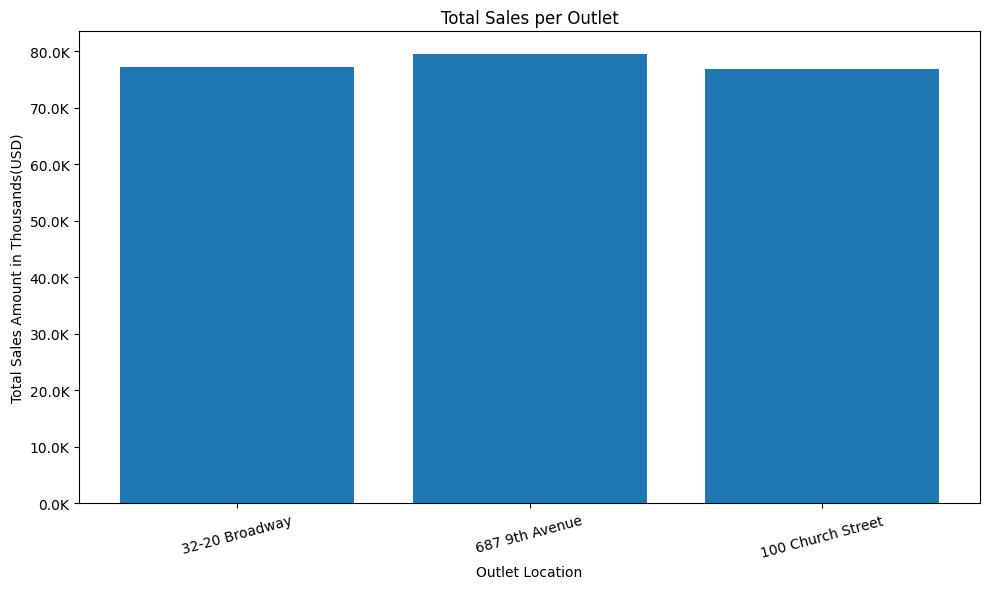

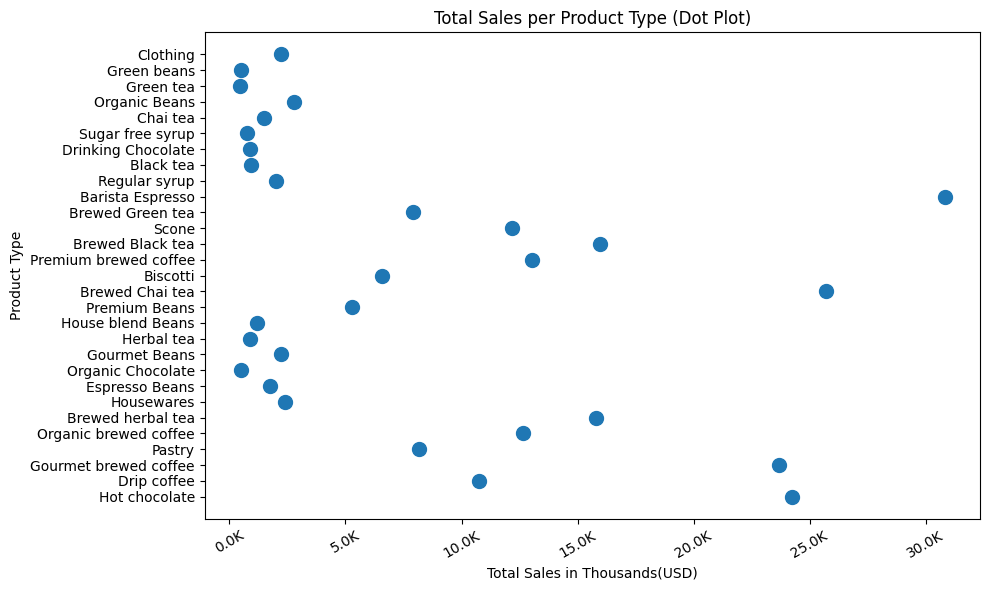

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49894 entries, 0 to 49893
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   sales_outlet_id          49894 non-null  int32         
 1   product_id               49894 non-null  int32         
 2   transaction_id           49894 non-null  int32         
 3   transaction_date         49894 non-null  object        
 4   transaction_time         49894 non-null  datetime64[ns]
 5   staff_id                 49894 non-null  int32         
 6   customer_id              49894 non-null  int32         
 7   instore_yn               49894 non-null  object        
 8   order                    49894 non-null  int32         
 9   line_item_id             49894 non-null  int32         
 10  quantity                 49894 non-null  int32         
 11  line_item_amount         49894 non-null  float64       
 12  unit_price               49894 n

<ipython-input-5-a3611f7dc59f>:55: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  coffee_corr_matrix = pandas_df.corr()


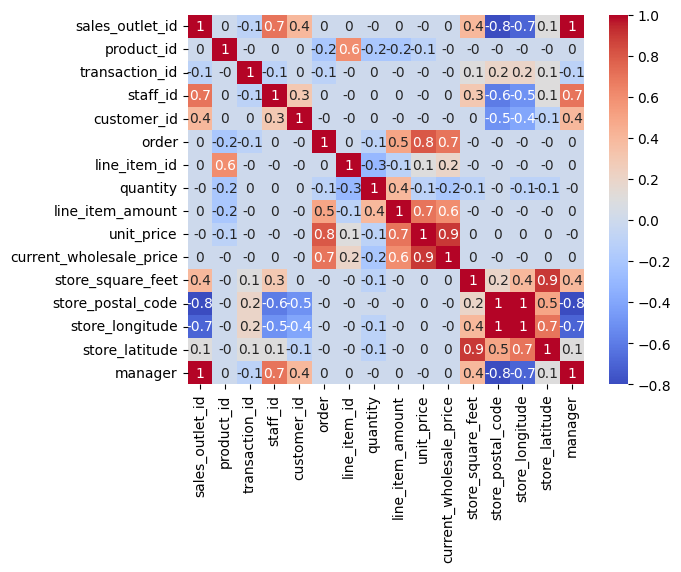

<Figure size 1000x600 with 0 Axes>

In [ ]:


#Use the rdd property to convert your DataFrame into an RDD.
#Then,use the reduceByKey transformation to calculate the total sales per outlet:
rdd = finalest_table.rdd.map(lambda x: (x['store_address'], x['line_item_amount']))
totals = rdd.reduceByKey(lambda a, b: a + b).collect()

#Convert the results to a Pandas DataFrame for plotting:
totals_df = pd.DataFrame(totals, columns=['store_address', 'line_item_amount'])
def thousands_formatter(x, pos):
    return f'{x / 1e3:.1f}K'

#plot the results
plt.figure(figsize=(10, 6))
plt.bar(totals_df['store_address'], totals_df['line_item_amount'])
plt.xlabel('Outlet Location')
plt.ylabel('Total Sales Amount in Thousands(USD)')
plt.title('Total Sales per Outlet')
plt.xticks(rotation = 15)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Apply the formatter
plt.tight_layout()
plt.show()

# Convert DataFrame to RDD, where each element is a tuple of (product_type, total_sales)
rdd1 = finalest_table.rdd.map(lambda x: (x['product_type'], x['line_item_amount'])).reduceByKey(lambda a, b: a + b)

# Collect the results
results = rdd1.collect()

# Extract data for plotting
product_types = [result[0] for result in results]
total_sales = [result[1] for result in results]

# Create the dot plot
plt.figure(figsize=(10, 6))
plt.plot(total_sales, product_types, 'o', markersize=10)
plt.xlabel('Total Sales in Thousands(USD)')
plt.ylabel('Product Type')
plt.title('Total Sales per Product Type (Dot Plot)')
plt.xticks(rotation = 30)
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Apply the formatter

# Show the plot
plt.tight_layout()
plt.show()

#convert spark dataframe to pandas dataframe
pandas_df = finalest_table.toPandas()

# display additional information about the dataset
pandas_df.info()



# Compute the correlation matrix of the variables
coffee_corr_matrix = pandas_df.corr()

# Round off values to one decimal place using NumPy
rounded_matrix = np.round(coffee_corr_matrix, 1)

# Print the rounded matrix
#print(rounded_matrix)


# Create the heatmap using the `heatmap` function of Seaborn
sns.heatmap(rounded_matrix, cmap='coolwarm', annot=True)

# Display the heatmap using the `show` method of the `pyplot` module from matplotlib.
plt.figure(figsize=(10, 6))
plt.show()





# Stop the spark session
spark.stop()








## Since the attributes are very many in the joined dataset, we will use just some of them in our predictions to ensure a highly accurate prediction.

In [ ]:
#encode categorical columns
cat_columns = list(pandas_df.select_dtypes(include=["category"]).columns)
print(cat_columns)
for c in cat_columns:
        lencoder = preprocessing.LabelEncoder()
        pandas_df.loc[:, c] = lencoder.fit_transform(pandas_df.loc[:, c]).copy()

[]


In [ ]:
# Remove leading and trailing whitespaces from column names
pandas_df.columns = pandas_df.columns.str.strip()

# After label encoding
pandas_df.head()

,sales_outlet_id,product_id,transaction_id,transaction_date,staff_id,customer_id,instore_yn,order,line_item_id,quantity,...,store_square_feet,store_address,store_city,store_state_province,store_telephone,store_postal_code,store_longitude,store_latitude,manager,Neighorhood
0,3,54,1402,2019-04-01,17,230,Y,1,1,1,...,1300,32-20 Broadway,Long Island City,NY,777-718-3190,11106,-73.924008,40.761196,6,Astoria
1,3,69,1737,2019-04-01,12,60,N,1,5,1,...,1300,32-20 Broadway,Long Island City,NY,777-718-3190,11106,-73.924008,40.761196,6,Astoria
2,8,36,201,2019-04-01,42,8191,Y,1,1,1,...,1500,687 9th Avenue,New York,NY,652-212-7020,10036,-73.990338,40.761887,31,Hell's Kitchen
3,8,61,2687,2019-04-01,45,8180,N,1,1,1,...,1500,687 9th Avenue,New York,NY,652-212-7020,10036,-73.990338,40.761887,31,Hell's Kitchen
4,3,24,331,2019-04-02,12,418,Y,1,1,2,...,1300,32-20 Broadway,Long Island City,NY,777-718-3190,11106,-73.924008,40.761196,6,Astoria


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['sales_outlet_id'].plot(kind='hist', bins=20, title='sales_outlet_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['product_id'].plot(kind='hist', bins=20, title='product_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['transaction_id'].plot(kind='hist', bins=20, title='transaction_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('transaction_date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('instore_yn').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('product_group').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('product_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='index', y='sales_outlet_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='sales_outlet_id', y='product_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='product_id', y='transaction_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='transaction_id', y='staff_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['sales_outlet_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('transaction_date')):
  _plot_series(series, series_name, i)
  fig.legend(title='transaction_date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('sales_outlet_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['sales_outlet_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('instore_yn')):
  _plot_series(series, series_name, i)
  fig.legend(title='instore_yn', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('sales_outlet_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['sales_outlet_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('product_group')):
  _plot_series(series, series_name, i)
  fig.legend(title='product_group', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('sales_outlet_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['sales_outlet_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('product_category')):
  _plot_series(series, series_name, i)
  fig.legend(title='product_category', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('sales_outlet_id')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['sales_outlet_id'].plot(kind='line', figsize=(8, 4), title='sales_outlet_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['product_id'].plot(kind='line', figsize=(8, 4), title='product_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['transaction_id'].plot(kind='line', figsize=(8, 4), title='transaction_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['instore_yn'].value_counts()
    for x_label, grp in _df_20.groupby('transaction_date')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('transaction_date')
_ = plt.ylabel('instore_yn')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['product_group'].value_counts()
    for x_label, grp in _df_21.groupby('instore_yn')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('instore_yn')
_ = plt.ylabel('product_group')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['product_category'].value_counts()
    for x_label, grp in _df_22.groupby('product_group')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('product_group')
_ = plt.ylabel('product_category')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['product_type'].value_counts()
    for x_label, grp in _df_23.groupby('product_category')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('product_category')
_ = plt.ylabel('product_type')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['transaction_date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='index', y='transaction_date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['instore_yn'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='index', y='instore_yn', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['product_group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='index', y='product_group', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['product_category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='index', y='product_category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Set predictor and responce variables X and y

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')



#drop some columns

df = pandas_df.drop(['transaction_date',  'promo_item_yn', 'product_group', 'product_category', 'product_type', 'product', 'product_description', 'unit_of_measure', 'current_retail_price', 'instore_yn', 'store_latitude','store_longitude','promo_yn','tax_exempt_yn','new_product_yn', 'sales_outlet_type', 'store_state_province','store_address', 'store_city', 'store_telephone', 'Neighorhood'], axis=1)


X = df.drop(['line_item_amount'], axis=1)

y = df['line_item_amount']

df.info()



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49894 entries, 0 to 49893
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sales_outlet_id          49894 non-null  int32  
 1   product_id               49894 non-null  int32  
 2   transaction_id           49894 non-null  int32  
 3   staff_id                 49894 non-null  int32  
 4   customer_id              49894 non-null  int32  
 5   order                    49894 non-null  int32  
 6   line_item_id             49894 non-null  int32  
 7   quantity                 49894 non-null  int32  
 8   line_item_amount         49894 non-null  float64
 9   unit_price               49894 non-null  float64
 10  current_wholesale_price  49894 non-null  float64
 11  store_square_feet        49894 non-null  int32  
 12  store_postal_code        49894 non-null  int32  
 13  manager                  49894 non-null  int32  
dtypes: float64(3), int32(1

##Linear Regression

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 6.966584653061083


The MSE is quite high meaning that the model performance is not satisfactory

# Feature Importance

Feature Coefficients:
                    Feature  Coefficient
0           sales_outlet_id     0.000002
1                product_id    -0.004377
2            transaction_id     0.000036
3                  staff_id     0.000993
4               customer_id    -0.000007
5                     order    -0.361598
6              line_item_id     0.127681
7                  quantity     3.620688
8                unit_price     1.264778
9   current_wholesale_price     0.008932
10        store_square_feet     0.000272
11        store_postal_code    -0.000042
12                  manager     0.000008


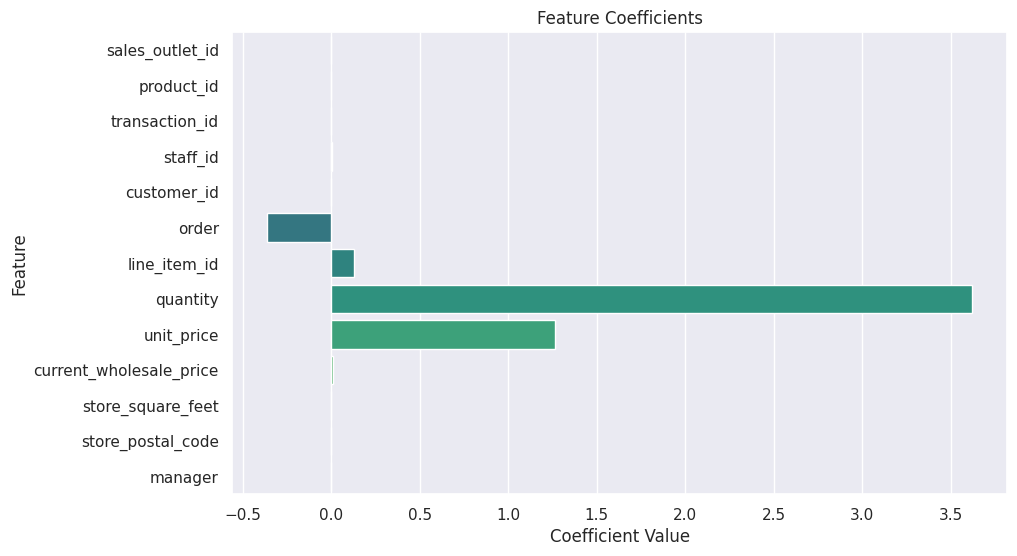

In [ ]:
coefficients = model.coef_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Display the table
print("Feature Coefficients:")
print(feature_importance)


# Create a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Select Bottom 2 Features to Drop
drop_features = feature_importance[-2:]['Feature']




# XGBOOST

       Actual  Predicted
48749    3.25   3.228567
23099    7.50   7.450209
44792    6.00   6.002047
47706    3.75   3.616579
32082    5.00   4.976485


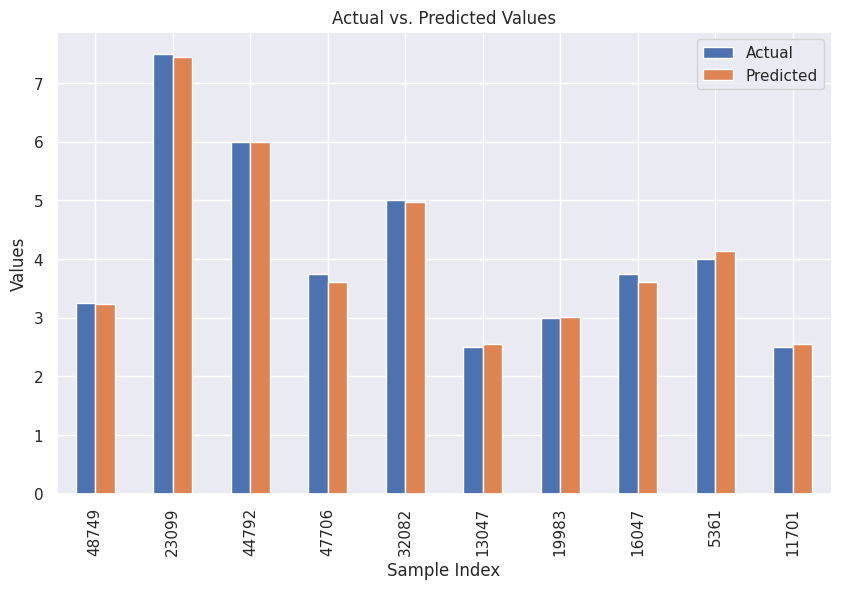

Root Mean Squared Error (RMSE): 0.4186285346126691
R-squared (R2): 0.9909025974345902
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
XGBOOST FEATURE IMPORTANCE


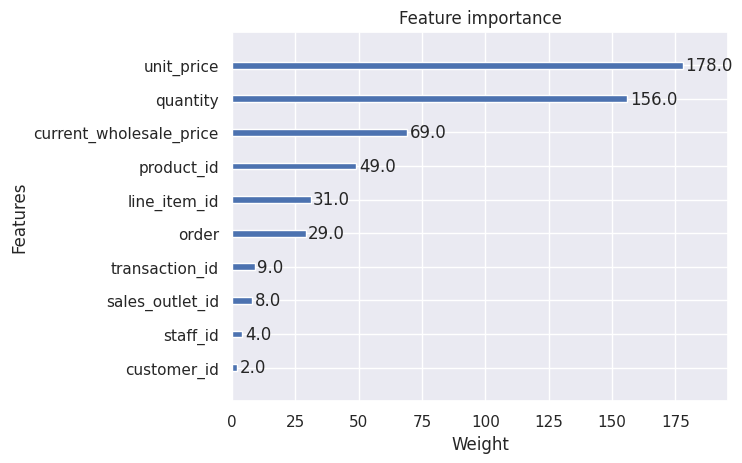

In [ ]:
import xgboost as xgb

# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters for regression
params = {
    'objective': 'reg:squarederror',  # 'reg:squarederror' for regression
    'eval_metric': 'rmse',             # Use RMSE for evaluation
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = xgb_model.predict(dtest)

# Create a DataFrame with actual and predicted values
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the DataFrame
print(result_df.head())

# Create a bar chart
result_df.head(10).plot(kind='bar', figsize=(10, 6))
plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.show()

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2): {r2}')

print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('XGBOOST FEATURE IMPORTANCE')


# Feature Importance Plot
xgb.plot_importance(xgb_model, importance_type='weight', xlabel='Weight')
plt.show()

**Root Mean Squared Error (RMSE):**
RMSE is a measure of the average magnitude of the errors between predicted and actual values. In this case, having an RMSE of 0.4186 indicates that, on average, the model's predictions are off by approximately 0.42 units from the actual values.

**R-squared (R2):**
R-squared is a measure of how well the model explains the variability in the data. An R2 value of 0.9909 is very high, suggesting that your model explains about 99.09% of the variance in the target variable. This is an excellent fit, close to a perfect match.


## Random Forest

Root Mean Squared Error (RMSE): 0.5900338068992693
R-squared (R2): 0.9819276948971468


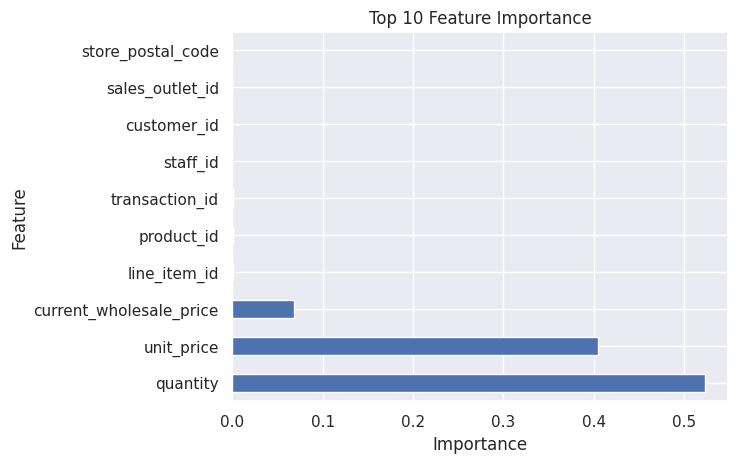

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Feature Importance Plot
feature_importance = pd.Series(rf_regressor.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The performance of XGBOOST and random forest is very close but XGBOOST performs better overall.


The task was a regression task, and thus used regressor models. This is because

**The target Variable is Continuous:**

Target variable is numeric and represents a continuous quantity (i.e., line_item_amount).

**Prediction of Quantity:**

The goal was to predict a quantity or a numerical value, line_item_amount

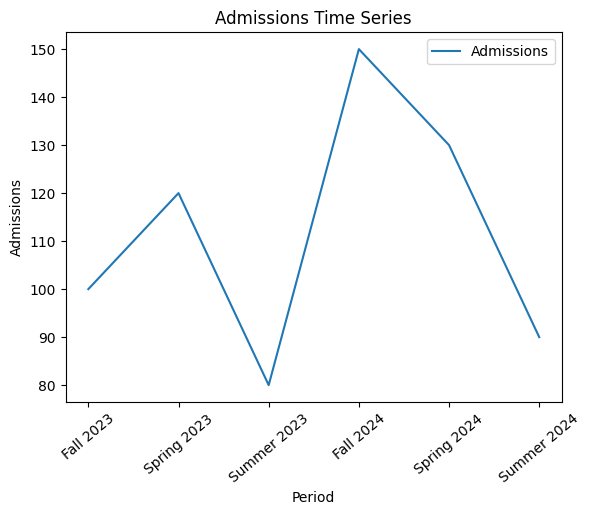

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Sample data with periods
data = {
    'Period': ["Fall 2023", "Spring 2023", "Summer 2023", "Fall 2024", "Spring 2024", "Summer 2024"],
    'Admissions': [100, 120, 80, 150, 130, 90]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Convert the 'Period' column to datetime format
#df['Period'] = pd.to_datetime(df['Period'], format='%B %Y')

# Set the 'Period' column as the index (optional but useful for time series analysis)
df.set_index('Period', inplace=True)

# Plot the time series
df.plot(title='Admissions Time Series', xlabel='Period', ylabel='Admissions')

# Show the plot
plt.xticks(rotation = 40)
plt.show()

In [ ]:
!pip install hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import panel as pn
import hvplot.pandas

# Sample data (replace this with your actual data)
data = {
    'Year': [2018, 2018, 2019, 2019, 2020, 2020],
    'Program': ['Computer Science', 'Electrical Engineering', 'Computer Science', 'Electrical Engineering', 'Computer Science', 'Electrical Engineering'],
    'Admissions': [100, 120, 150, 130, 180, 160],
    'Enrollment': [90, 110, 140, 120, 170, 150]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Group by Year and Program to get total admissions and enrollment per year per program
grouped_data = df.groupby(['Year', 'Program']).sum().reset_index()

# Create Panel widgets
year_selector = pn.widgets.IntRangeSlider(name='Select Year Range', start=df['Year'].min(), end=df['Year'].max(), value=(df['Year'].min(), df['Year'].max()))

# Function to update the plots based on selected year range
def update_plots(year_range):
    selected_data = grouped_data[(grouped_data['Year'] >= year_range[0]) & (grouped_data['Year'] <= year_range[1])]

    # Admissions Trend
    admissions_plot = selected_data.hvplot.line(x='Year', y='Admissions', by='Program', title='Admissions Trend Over the Years', ylabel='Total Admissions', legend='top_right')

    # Enrollment Trend
    enrollment_plot = selected_data.hvplot.line(x='Year', y='Enrollment', by='Program', title='Enrollment Trend Over the Years', ylabel='Total Enrollment', legend='top_right')

    return pn.Column(admissions_plot, enrollment_plot)

# Define the app layout
app_layout = pn.Column(
    "# Student Admissions Dashboard",
    year_selector,
    pn.bind(update_plots, year_selector.param.value)
)

# Run the app
app_layout.servable()

Column
    [0] Markdown(str)
    [1] IntRangeSlider(end=2020, name='Select Year Range', start=2018, value=(2018, 2020), value_end=2020, value_start=2018)
    [2] ParamFunction(function, _pane=Column, defer_load=False)

In [ ]:
pip install nltk wordcloud

Year 2022: Total Applications = 2
Year 2023: Total Applications = 3


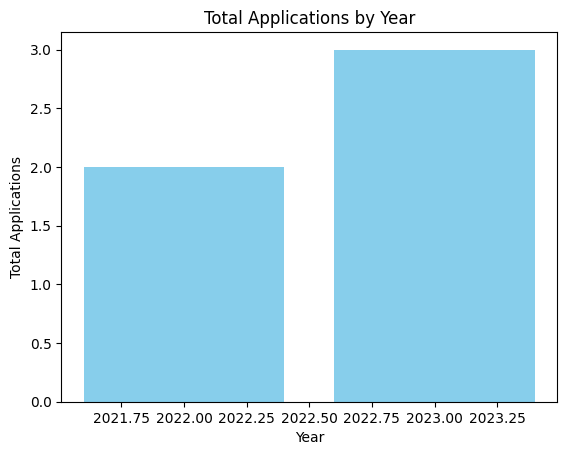

In [ ]:
from itertools import groupby
from functools import reduce

# Sample data (replace with your actual data)
applications = [
    {'year': 2022, 'applicant': 'John Doe'},
    {'year': 2022, 'applicant': 'Jane Doe'},
    {'year': 2023, 'applicant': 'Alice Smith'},
    {'year': 2023, 'applicant': 'Bob Johnson'},
    {'year': 2023, 'applicant': 'Charlie Brown'},
    # Add more application data...
]

# Define a function to combine the counts for each year
def combine_counts(acc, item):
    year, group = item
    total_applications = len(list(group))
    acc[year] = total_applications
    return acc

# Sort the data by year
sorted_applications = sorted(applications, key=lambda x: x['year'])

# Use groupby to group applications by year
grouped_by_year = groupby(sorted_applications, key=lambda x: x['year'])

# Use reduce to combine counts for each year
result = reduce(combine_counts, grouped_by_year, {})

# Print the result
for year, total_applications in result.items():
    print(f"Year {year}: Total Applications = {total_applications}")
# Plotting the results
years = list(result.keys())
total_applications = list(result.values())

plt.bar(years, total_applications, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total Applications')
plt.title('Total Applications by Year')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


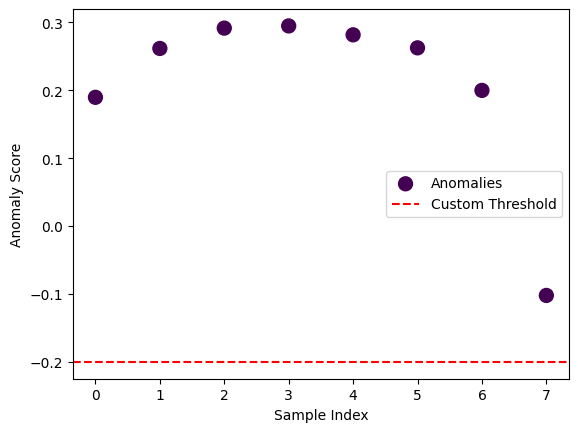

Anomalies:
Empty DataFrame
Columns: [Metric1, Metric2, anomaly_score, is_anomaly]
Index: []


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Sample data (replace with your actual admissions data)
data = {
    'Metric1': [10, 15, 20, 25, 30, 35, 40, 200],
    'Metric2': [1, 2, 3, 4, 5, 6, 7, 100],
    # Add more metrics...
}

df = pd.DataFrame(data)

# Train Isolation Forest model
clf = IsolationForest(contamination=0.05)  # Adjust contamination based on your dataset characteristics
clf.fit(df)

# Predict anomalies (outliers)
df['anomaly_score'] = clf.decision_function(df)

# Set a custom threshold for identifying anomalies
threshold = -0.2  # Adjust based on your dataset and desired sensitivity
df['is_anomaly'] = df['anomaly_score'] < threshold

# Visualize anomalies
plt.scatter(df.index, df['anomaly_score'], c=df['is_anomaly'], cmap='viridis', label='Anomalies', s=100)
plt.axhline(y=threshold, color='red', linestyle='--', label='Custom Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

# Identify anomalies
anomalies = df[df['is_anomaly']]
print("Anomalies:")
print(anomalies)